<a href="https://colab.research.google.com/github/Ankit-LASA/Data-Science/blob/main/AnkiBhasU8proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

In [2]:
!pip install preliz

In [3]:
import preliz as pz

In [4]:
!pip install pymc-bart

In [5]:
import pymc_bart as pmb

# Unit 8 Project: Height

## Introduction

Everyday, decomposing bodies from natural disasters, accidental death, and crime are discovered throughout the world. One of the first actions taken by the police is to identify who the remains belonged to in order to help notify family members and/or begin an investigation. However, due to the nature of decomposition and the fact that skeletal remains are sometimes incomplete, traditional identification methods in forensic analysis fail. In these instances, investigators rely on prominent physical characteristics such as age, ethnicity, and height to cross reference with missing persons reports. As discussed earlier, such aspects of individuals are nearly impossible to ascertain in numerous cases.

However, the police can use bones to identify other physical characteristics to identify a person's gender, age, ethnicity, and height. By using forensic analysis, they are able to reverse-engineer information about an person, helping families find closure. To discover which such features are most important, I wanted to cross reference identifiable skeletal traits with height, a unique attribute critical to physical identification.

To investigate the correlation of height with physical traits, I took a dataset of height, hand length, foot length, and gender in order to observe which traits are reasonably accurate predictors for height.

## Model

In [6]:
#import
#drop the incomplete rows from the data
url = "https://raw.githubusercontent.com/Ankit-LASA/Data-Science/refs/heads/main/stature_hand_foot.csv"
bodyType = pd.read_csv(url).dropna()

In [7]:
bodyType

,idGen,gender,height,handLen,footLen
0,1,1,1829.356,205.7455,294.1762
1,2,1,1730.262,197.5946,283.2275
2,3,1,1723.990,193.6019,238.9127
3,4,1,1748.885,224.5994,289.4070
4,5,1,1697.573,200.8021,247.0631
...,...,...,...,...,...
150,71,2,1546.848,182.3627,222.5443
151,72,2,1602.703,188.1426,235.4272
152,73,2,1671.917,189.6964,250.4256
153,74,2,1625.468,188.1226,228.7377


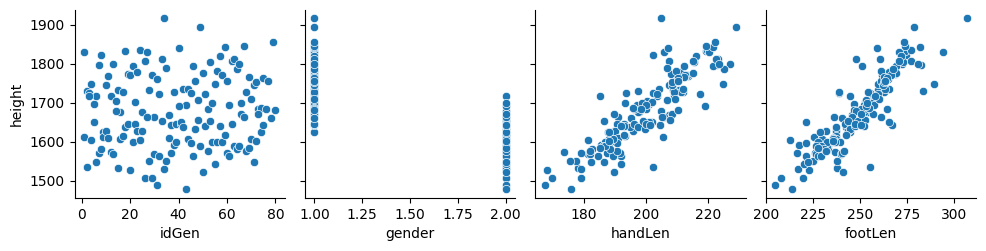

In [8]:
sns.pairplot(bodyType, y_vars=['height'], x_vars=bodyType.columns.drop('height'), kind='scatter')

As expected, the idGen is entirely randomized due to its random assignment while the other variables (gender, hand length, and foot length) demonstrate a correlation as follows:

---Gender: Men have a higher height than women, but it's more of a general trend than a strict correlation because many women are taller than men

---Hand Length: A relatively tight, linear correlation with height

---Foot Length: Similar to hand length; shows a linear correlation with height

Due to the lack of a connection with the id #, I'll exclude it from the BART model entirely.

In [9]:
#features = ['gender', 'handLen', 'footLen']]
#need to combine multiple into one
X = bodyType[['gender', 'handLen', 'footLen']]
#copy from code
Y = bodyType['height'].to_numpy()

In [10]:
#this is mostly just copied from the code, but the likelihood is changed
#the reason why I'm using normal was done above on the histogram
with pm.Model() as model_BART:
    s = pm.HalfNormal('s',20) #sigma = 20 is a blind guess
    μ_ = pmb.BART("μ_", X, np.log(Y), m=50) #log around Y
    μ = pm.Deterministic("μ",pm.math.exp(μ_)) #exp it all once BART is done
    y = pm.Normal("y", mu=μ, sigma=s,  observed=Y) #likelihood
    idata_BART = pm.sample(compute_convergence_checks=False)

 Progress                    Draws   Divergences   Step size   Grad evals   Sampling Speed   Elapsed   Remaining  
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  ━━━━━━━━━━━━━━━━━━━━━━━━━   2000    0             1.12        3            30.77 draws/s    0:01:04   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━   2000    0             1.35        3            16.13 draws/s    0:02:03   0:00:00

In [11]:
#copy
pm.sample_posterior_predictive(idata_BART,model_BART, extend_inferencedata=True)

Sampling ... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:00:00

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

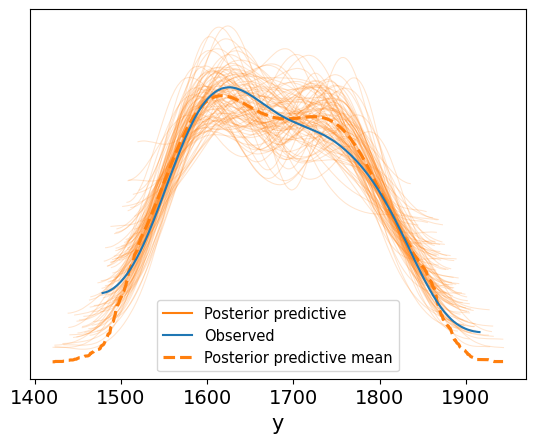

In [12]:
ax = az.plot_ppc(idata_BART, num_pp_samples=100, colors=["C1", "C0", "C1"])

This data looks incredibly accurate for my first model. The poster predictive strongly matches the obersved data.

Next, I wanted to see/observe the impact of each predictor overall for the dataset to compare and attempt to reach a final model. To do so, I'll isolate each and model the posterior for each model.

In [13]:
posterior_mean = idata_BART.posterior["μ"]

μ_hdi = az.hdi(ary=idata_BART, group="posterior", var_names=["μ"], hdi_prob=0.74)

pps = az.extract(
    idata_BART, group="posterior_predictive", var_names=["y"]
).T

/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


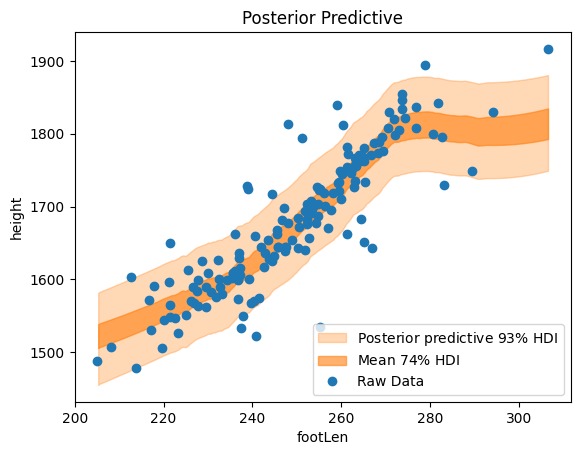

In [14]:
idx = np.argsort(bodyType.footLen)
fig, ax = plt.subplots()
az.plot_hdi(
    x=bodyType.footLen,
    y=pps,
    ax=ax,
    hdi_prob=0.93,
    fill_kwargs={"alpha": 0.3, "label": r"Posterior predictive $93\%$ HDI"},
)
az.plot_hdi(
    x=bodyType.footLen,
    y=posterior_mean,
    ax=ax,
    hdi_prob=0.74,
    fill_kwargs={"alpha": 0.6, "label": r"Mean $74\%$ HDI"},
)
ax.plot(bodyType['footLen'], bodyType["height"], "o", c="C0", label="Raw Data")
ax.legend(loc="lower right")
ax.set(
    title="Posterior Predictive",
    xlabel="footLen",
    ylabel="height",
);

Even though it has a litany of outliers, this data set seems reasonably accurate.

/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


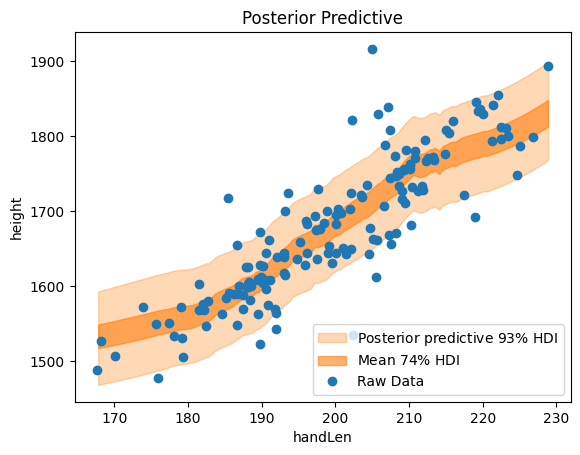

In [15]:
idx = np.argsort(bodyType.handLen)
fig, ax = plt.subplots()
az.plot_hdi(
    x=bodyType.handLen,
    y=pps,
    ax=ax,
    hdi_prob=0.93,
    fill_kwargs={"alpha": 0.3, "label": r"Posterior predictive $93\%$ HDI"},
)
az.plot_hdi(
    x=bodyType.handLen,
    y=posterior_mean,
    ax=ax,
    hdi_prob=0.74,
    fill_kwargs={"alpha": 0.6, "label": r"Mean $74\%$ HDI"},
)
ax.plot(bodyType['handLen'], bodyType["height"], "o", c="C0", label="Raw Data")
ax.legend(loc="lower right")
ax.set(
    title="Posterior Predictive",
    xlabel="handLen",
    ylabel="height",
);

In a seemingly recurring trend, the hand length model strongly correlates with the foot length model. It also shows a reasonably accurate linear correlation with a few outliers.

/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


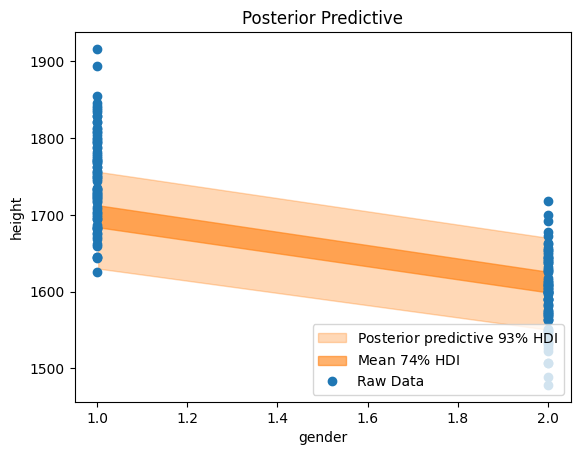

In [16]:
idx = np.argsort(bodyType.gender)
fig, ax = plt.subplots()
az.plot_hdi(
    x=bodyType.gender,
    y=pps,
    ax=ax,
    hdi_prob=0.93,
    fill_kwargs={"alpha": 0.3, "label": r"Posterior predictive $93\%$ HDI"},
)
az.plot_hdi(
    x=bodyType.gender,
    y=posterior_mean,
    ax=ax,
    hdi_prob=0.74,
    fill_kwargs={"alpha": 0.6, "label": r"Mean $74\%$ HDI"},
)
ax.plot(bodyType['gender'], bodyType["height"], "o", c="C0", label="Raw Data")
ax.legend(loc="lower right")
ax.set(
    title="Posterior Predictive",
    xlabel="gender",
    ylabel="height",
);

Gender has the weakest correlation with height; there's a ton of outliers with the posterior predictive.

array([<Axes: xlabel='gender'>, <Axes: xlabel='handLen'>,
       <Axes: xlabel='footLen'>], dtype=object)

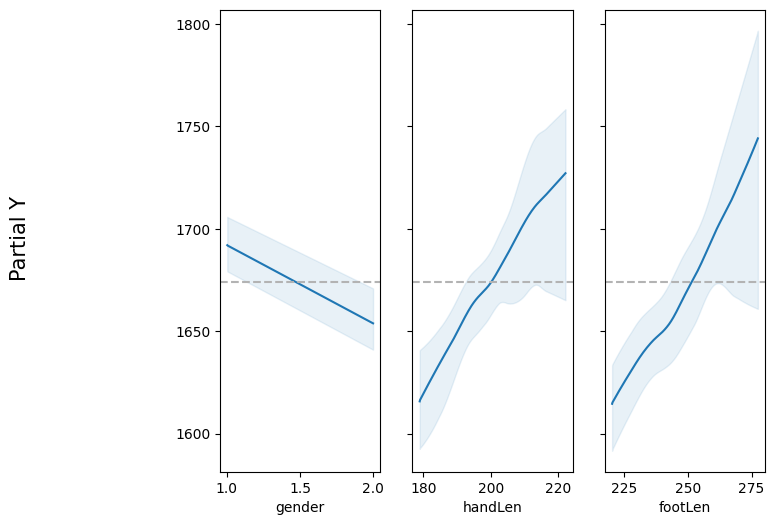

In [17]:
pmb.plot_pdp(μ_, X, Y, grid=(1, 5), func=np.exp, figsize = (12,6))

array([<Axes: xlabel='gender'>, <Axes: xlabel='handLen'>,
       <Axes: xlabel='footLen'>], dtype=object)

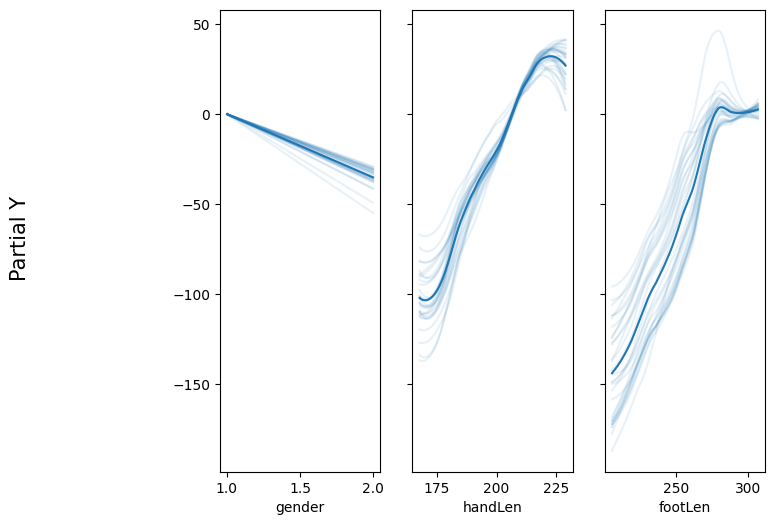

In [18]:
pmb.plot_ice( μ_, X, Y, grid=(1, 5), func=np.exp, figsize = (12,6))

In [19]:
vi_BART = pmb.compute_variable_importance(idata_BART, μ_, X)

<Axes: ylabel='R²'>

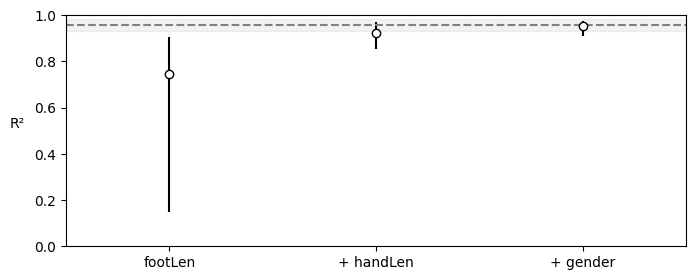

In [20]:
pmb.plot_variable_importance(vi_BART)

## Conclusion

After looking at the BART model of food length, gender, and hand length, it seems that foot and hand length are the best predictors of someone's height. While gender does show a slight connection, it's FAR weaker than the other two predctors, so foot and hand length should be given comparatively higher importance to reduce complexity.

As explained above on each respective predictor's PPC, all three variables show a relatively linear relationship with height to different degrees. Gender is weaker with a number of outliers, while the hand and foot length have a much tighter correlation. However, the respective accuracy of foot and hand length seem to taper off as they get to higher amounts. That is shown by the fact that both the PPC and ICE plots flatten out or show an inverse correlation is the latter fifth of the chart. An important feature to note is that the gender ICE plot is artificially distorted to seem more accurate at the beginning because there are solely TWO categories (one for men and one for women). Both hthe and and foot length ICE plots show signs of divergence throughout with the number of 'outlier' lines being magnified at the beginning and end. However, the foot length seems to be slightly more accurate than the hand length with less divergences which is confirmed by the variable importance plot explained below.

As explained in the Unit8 notes, the partial dependence plots (PDP) will be given less analytical weight because gender, foot length, and hand length have extremely weak but albeit existent interactions with one another. Gender has a correlation to changes in hand and foot lengths due to physiological differences in skeletal structures between males and females. However, as explained above, such trends are relatively minor, so they should be given a limited amount of weight. As such, it's important to analyze where the ICE plots don't show a parallel trend with one another. The variable importance model further confirms these trends: both foot and hand length show significant increases in accuracy while gender shows a comparatively minor effect. That means that it produces a strong diminishing return compared to the other two whilst increasing the complexity and thereby risking overfitting. To put it simply, foot and hand length are critical to the predictive accuracy of one's height, while gender contributes very little. At the end, the variables in convergence seem to be strong predictors with a end accuracy nearing 1.

The data tracks with my own  knowledge in the context of people's heights. While men are typically taller than women, it's quite common for women to be taller in numerous instances. Comparatively, foot and hand length are stronger predictors because while there are instances where the correlation doesn't come true, these are outliers at best; in the vast majority of cases, a longer foot or hand means you're taller. However, as I've indicated above, none of the variables show a 100% correlation, so they shouldn't be used in place of finding someone's actual physical height when it's easily accessible.

An essential aspect of the analysis to note is that multiple predictors are anticasual. In other words, height typically causes an increased foot and hand length, rather than the other way around. Typically, it's extremely simple to observe the height by measuring the remains itself. Using other measures as predictors is reserved to extremely rare instances where finding the height is impossible, so the connections found are relatively insignificant in the vast majority of situations.